# 리테일 데이터 분석


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set_theme(style="darkgrid", palette="deep")

retail = pd.read_csv('OnlineRetailClean.csv')

retail = retail.drop('Unnamed: 0', axis=1)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,CheckoutPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [2]:
# 첫해 구매 고객들
first_year_customers = retail[retail['InvoiceDate'].between('2009-12', '2010-11')]
first_year_customer_ids = first_year_customers['Customer ID'].unique()

# 첫해 구매 고객들 중 둘째해에도 구매한 고객들
second_year_customers = retail[retail['InvoiceDate'].between('2010-12', '2011-11') & retail['Customer ID'].isin(first_year_customer_ids)]
second_year_customer_ids = second_year_customers['Customer ID'].unique()

# 연간 재구매율 계산
repurchase_rate = len(second_year_customer_ids) / len(first_year_customer_ids)
repurchase_rate

0.6183709718345598

---

## RFM

In [3]:
# 연도와 월 추출
retail['Year'] = retail['InvoiceDate'].dt.year
retail['Month'] = retail['InvoiceDate'].dt.month

# 특정 년월 범위로 데이터 분리
retail_1st = retail[(retail['Year'] == 2009) & (retail['Month'] >= 12) | (retail['Year'] == 2010) & (retail['Month'] <= 11)]
retail_2nd = retail[(retail['Year'] == 2010) & (retail['Month'] >= 12) | (retail['Year'] == 2011) & (retail['Month'] <= 11)]

# 각 년월 범위별 데이터에 대해 RFM 등급 부여
def calculate_rfm(data):
    rfm_data = data.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (data['InvoiceDate'].max() - x.max()).days,
        'Invoice': 'nunique',
        'CheckoutPrice': 'sum'
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency',
        'CheckoutPrice': 'Monetary'
    })

    rfm_data['R'] = pd.qcut(rfm_data['Recency'], q=5, labels=False)
    rfm_data['R'] = 4 - rfm_data['R']
    rfm_data['F'] = pd.qcut(rfm_data['Frequency'], q=5, labels=False, duplicates='drop')
    rfm_data['M'] = pd.qcut(rfm_data['Monetary'], q=5, labels=False, duplicates='drop')

    rfm_data['RFM_Score'] = rfm_data['R'] + rfm_data['F'] + rfm_data['M']

    def assign_grade(row): 
        if row['M'] == 4: return 'VVIP' 
        elif row['M'] == 3 and row['RFM_Score'] >= 9: return 'VIP' 
        elif row['M'] == 3 and row['RFM_Score'] < 9: return 'GOLD' 
        elif row['M'] <= 2: 
            if row['RFM_Score'] <= rfm_data['RFM_Score'].quantile(0.5): return 'WHITE' 
            else: return 'SILVER'

    rfm_data['Grade'] = rfm_data.apply(assign_grade, axis=1)
    
    return rfm_data

rfm_data_1st = calculate_rfm(retail_1st)
rfm_data_2nd = calculate_rfm(retail_2nd)

rfm_data_1st

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Grade
Customer ID,,,,,,,,
12346.0,155,11,372.86,1,3,1,5,WHITE
12347.0,30,1,611.53,3,0,2,5,WHITE
12348.0,64,1,222.16,2,0,0,2,WHITE
12349.0,33,3,2671.14,3,1,4,8,VVIP
12351.0,1,1,300.93,4,0,1,5,WHITE
...,...,...,...,...,...,...,...,...
18283.0,8,6,619.37,4,2,2,8,SILVER
18284.0,57,1,461.68,2,0,1,3,WHITE
18285.0,286,1,427.00,0,0,1,1,WHITE


In [4]:
# 첫해 VVIP 고객들
first_year_vvip = rfm_data_1st[rfm_data_1st['Grade'] == 'VVIP']

# 둘째해 VVIP 고객들
second_year_vvip = rfm_data_2nd[rfm_data_2nd['Grade'] == 'VVIP']

first_year_vvip

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Grade
Customer ID,,,,,,,,
12349.0,33,3,2671.14,3,1,4,8,VVIP
12356.0,6,3,3560.30,4,1,4,9,VVIP
12357.0,14,2,12079.99,3,0,4,7,VVIP
12358.0,1,3,2719.01,4,1,4,9,VVIP
12359.0,51,6,2563.36,2,2,4,8,VVIP
...,...,...,...,...,...,...,...,...
18245.0,5,13,3757.92,4,3,4,11,VVIP
18251.0,71,8,21964.14,1,3,4,8,VVIP
18257.0,72,4,2262.52,1,2,4,7,VVIP


In [5]:
second_year_vvip

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Grade
Customer ID,,,,,,,,
12346.0,316,1,77183.60,0,0,4,4,VVIP
12347.0,30,6,4085.18,3,3,4,10,VVIP
12352.0,27,8,2506.04,3,3,4,10,VVIP
12356.0,13,3,2811.43,3,1,4,8,VVIP
12357.0,24,1,6207.67,3,0,4,7,VVIP
...,...,...,...,...,...,...,...,...
18251.0,78,1,4314.72,1,0,4,5,VVIP
18257.0,30,8,2337.63,3,3,4,10,VVIP
18259.0,15,3,2338.60,3,1,4,8,VVIP


In [6]:
# 트리맵 생성을 위한 데이터 작업
grade_counts_1st = rfm_data_1st['Grade'].value_counts()
grade_ratios_1st = grade_counts_1st / grade_counts_1st.sum()
grade_ratios_df_1st = pd.DataFrame(grade_ratios_1st).reset_index()
grade_ratios_df_1st.columns = ['Grade', 'Ratio']

grade_counts_2nd = rfm_data_2nd['Grade'].value_counts()
grade_ratios_2nd = grade_counts_2nd / grade_counts_2nd.sum()
grade_ratios_df_2nd = pd.DataFrame(grade_ratios_2nd).reset_index()
grade_ratios_df_2nd.columns = ['Grade', 'Ratio']

grade_ratios_df_1st

,Grade,Ratio
0,WHITE,0.529536
1,VVIP,0.199953
2,GOLD,0.149320
3,SILVER,0.070558
4,VIP,0.050633


In [7]:
# 첫해 트리맵 생성
color_discrete_map = {'WHITE': 'rgb(129,114,179)', 'SILVER': 'rgb(221,132,82)', 'GOLD': 'rgb(76,114,176)', 'VIP': 'rgb(85,168,104)', 'VVIP': 'rgb(196,78,82)'}

fig = px.treemap(grade_ratios_df_1st, path=['Grade'], values='Ratio', color='Grade', color_discrete_map=color_discrete_map)
fig.update_layout(title='Grade Distribution Treemap_1st Year', width=700, height=700)
fig.update_traces(textinfo="label+percent entry")
fig.show()

In [8]:
# 두번째 해 트리맵 생성
color_discrete_map = {'WHITE': 'rgb(129,114,179)', 'SILVER': 'rgb(221,132,82)', 'GOLD': 'rgb(76,114,176)', 'VIP': 'rgb(85,168,104)', 'VVIP': 'rgb(196,78,82)'}

fig = px.treemap(grade_ratios_df_2nd, path=['Grade'], values='Ratio', color='Grade', color_discrete_map=color_discrete_map)
fig.update_layout(title='Grade Distribution Treemap_2nd Year', width=700, height=700)
fig.update_traces(textinfo="label+percent entry")
fig.show()

In [9]:
# Monetray의 값이 다른 변수들에 비해 너무 크기 때문에 정규화를 진행, 이상치에 강건한 RobustScaler 사용
# RobustScaler 객체 생성
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# RobustScaler를 사용하여 정규화
rfm_normalized = rfm_data_1st.copy()
rfm_normalized[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_normalized[['Recency', 'Frequency', 'Monetary']])

# 첫해 Ternary plot 생성
color_discrete_map = {'WHITE': 'rgb(129,114,179)', 'SILVER': 'rgb(221,132,82)', 'GOLD': 'rgb(76,114,176)', 'VIP': 'rgb(85,168,104)', 'VVIP': 'rgb(196,78,82)'}

fig = px.scatter_ternary(rfm_normalized, a='Recency', b='Frequency', c='Monetary', color='Grade', opacity=0.7, color_discrete_map=color_discrete_map)
fig.update_layout(title='RFM Ternary Plot_1st Year', width=700, height=700)
fig.show()

In [10]:
# 마찬가지로 RobustScaler를 사용하여 정규화
rfm_normalized = rfm_data_2nd.copy()
rfm_normalized[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_normalized[['Recency', 'Frequency', 'Monetary']])

# 두번째해 Ternary plot 생성
color_discrete_map = {'WHITE': 'rgb(129,114,179)', 'SILVER': 'rgb(221,132,82)', 'GOLD': 'rgb(76,114,176)', 'VIP': 'rgb(85,168,104)', 'VVIP': 'rgb(196,78,82)'}

fig = px.scatter_ternary(rfm_normalized, a='Recency', b='Frequency', c='Monetary', color='Grade', opacity=0.7, color_discrete_map=color_discrete_map)
fig.update_layout(title='RFM Ternary Plot_2nd Year', width=700, height=700)
fig.show()

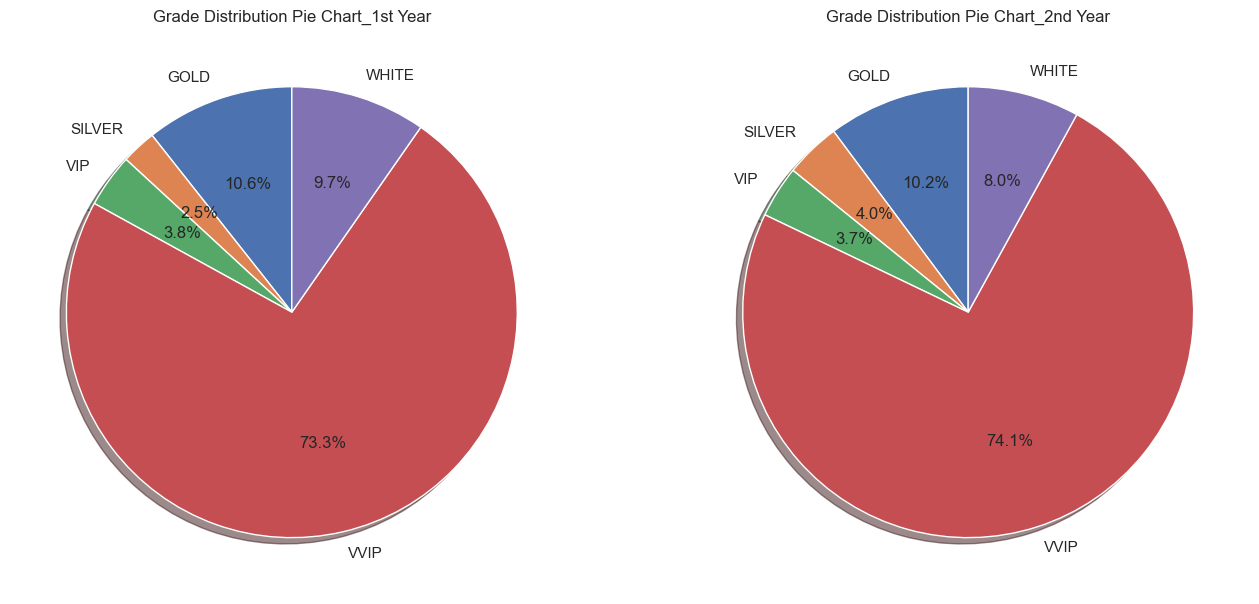

In [11]:
# 첫해 고객 등급별 매출 비율
grade_sales_1st = rfm_data_1st.groupby('Grade')['Monetary'].sum().reset_index()
grade_sales_1st['Ratio'] = grade_sales_1st['Monetary'] / grade_sales_1st['Monetary'].sum()

# 둘째해 고객 등급별 매출 비율
grade_sales_2nd = rfm_data_2nd.groupby('Grade')['Monetary'].sum().reset_index()
grade_sales_2nd['Ratio'] = grade_sales_2nd['Monetary'] / grade_sales_2nd['Monetary'].sum()

# 첫해 둘째해 고객 등급별 매출 비율을 파이차트로 생성.
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.pie(grade_sales_1st['Ratio'], labels=grade_sales_1st['Grade'], autopct='%1.1f%%', shadow=True, startangle=90 )
ax1.set_title('Grade Distribution Pie Chart_1st Year')

ax2.pie(grade_sales_2nd['Ratio'], labels=grade_sales_2nd['Grade'], autopct='%1.1f%%', shadow=True, startangle=90)
ax2.set_title('Grade Distribution Pie Chart_2nd Year')

plt.show()

In [12]:
# 첫해 VVIP 고객들의 상위 5개 Description과 지출액
first_year_vvip_top5 = retail_1st[retail_1st['Customer ID'].isin(first_year_vvip.index)].groupby('Description')['CheckoutPrice'].sum().nlargest(5)
first_year_vvip_top5

Description
REGENCY CAKESTAND 3 TIER              111710.10
WHITE HANGING HEART T-LIGHT HOLDER    109479.71
Manual                                 88234.70
ASSORTED COLOUR BIRD ORNAMENT          53067.81
JUMBO BAG RED RETROSPOT                42791.10
Name: CheckoutPrice, dtype: float64

In [13]:
# 둘째해 VVIP 고객들의 상위 5개 Description과 지출액
second_year_vvip_top5 = retail_2nd[retail_2nd['Customer ID'].isin(second_year_vvip.index)].groupby('Description')['CheckoutPrice'].sum().nlargest(5)
second_year_vvip_top5

Description
REGENCY CAKESTAND 3 TIER              113848.12
MEDIUM CERAMIC TOP STORAGE JAR         80310.96
WHITE HANGING HEART T-LIGHT HOLDER     76122.96
JUMBO BAG RED RETROSPOT                69418.95
POSTAGE                                54564.14
Name: CheckoutPrice, dtype: float64

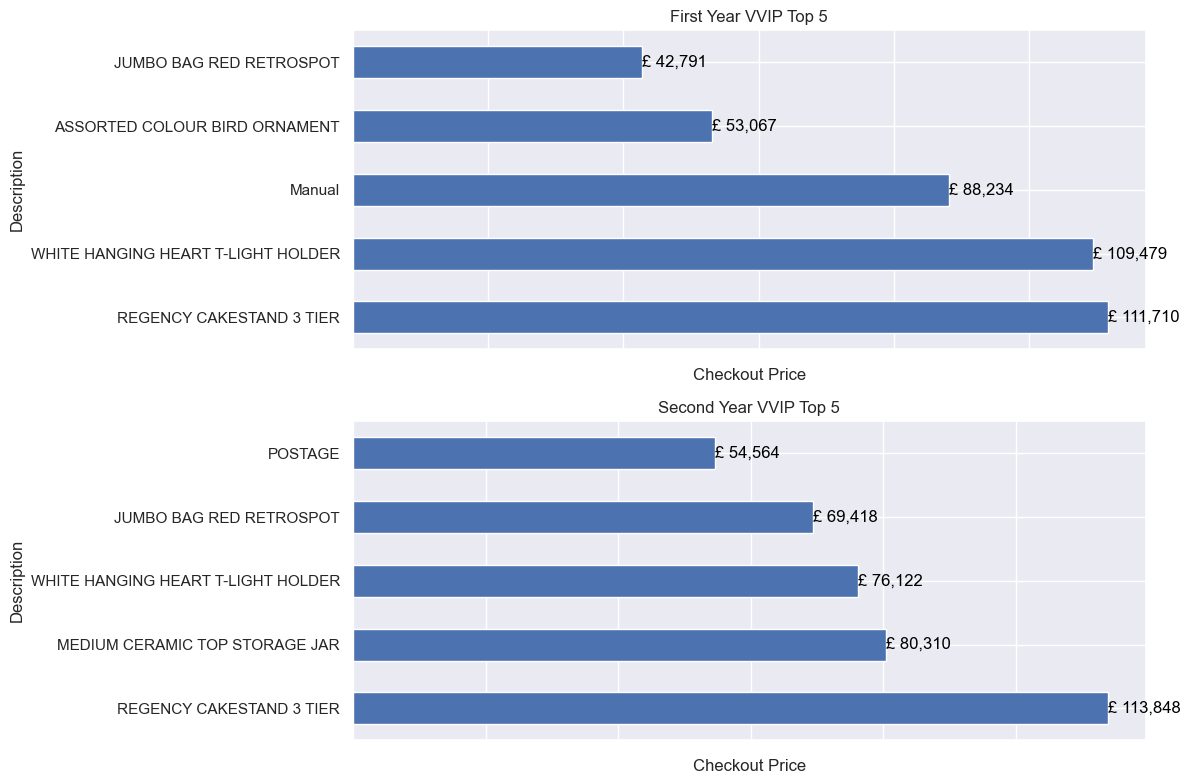

In [14]:
# 첫해, 둘째해 VVIP 고객들의 상위 5개 Description과 지출액을 막대그래프로 생성
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

first_year_vvip_top5.plot(kind='barh', ax=ax1)
ax1.set_title('First Year VVIP Top 5')
ax1.set_xlabel('Checkout Price')
ax1.set_ylabel('Description')
ax1.set_xticklabels([])  

for i, v in enumerate(first_year_vvip_top5):
    ax1.text(v, i, f'£ {int(v):,}', color='black', va='center')  

second_year_vvip_top5.plot(kind='barh', ax=ax2)
ax2.set_title('Second Year VVIP Top 5')
ax2.set_xlabel('Checkout Price')
ax2.set_ylabel('Description')
ax2.set_xticklabels([]) 

for i, v in enumerate(second_year_vvip_top5):
    ax2.text(v, i, f'£ {int(v):,}', color='black', va='center') 

plt.tight_layout()
plt.show()


In [15]:
# 첫해 VVIP 고객들 중 이탈 가능성이 있는 고객들
first_year_potential_leave_VVIP = first_year_vvip[first_year_vvip['R'] <= 2]
first_year_potential_leave_VVIP

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Grade
Customer ID,,,,,,,,
12359.0,51,6,2563.36,2,2,4,8,VVIP
12371.0,35,3,2179.42,2,1,4,7,VVIP
12374.0,47,3,2246.29,2,1,4,7,VVIP
12380.0,91,7,6951.49,1,3,4,8,VVIP
12391.0,90,5,2285.18,1,2,4,7,VVIP
...,...,...,...,...,...,...,...,...
18093.0,70,4,2346.19,1,2,4,7,VVIP
18094.0,72,6,3374.22,1,2,4,7,VVIP
18194.0,64,5,3188.20,2,2,4,8,VVIP


In [16]:
# 둘째해 VVIP 고객들 중 이탈 가능성이 있는 고객들
second_year_potential_leave_VVIP = second_year_vvip[second_year_vvip['R'] <= 2]
second_year_potential_leave_VVIP

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Grade
Customer ID,,,,,,,,
12346.0,316,1,77183.60,0,0,4,4,VVIP
12359.0,48,4,6310.03,2,2,4,8,VVIP
12360.0,43,3,2662.06,2,1,4,7,VVIP
12370.0,42,4,3541.94,2,2,4,8,VVIP
12378.0,120,1,4008.62,1,0,4,5,VVIP
...,...,...,...,...,...,...,...,...
18231.0,183,5,2071.77,0,2,4,6,VVIP
18242.0,63,4,2232.49,2,2,4,8,VVIP
18251.0,78,1,4314.72,1,0,4,5,VVIP


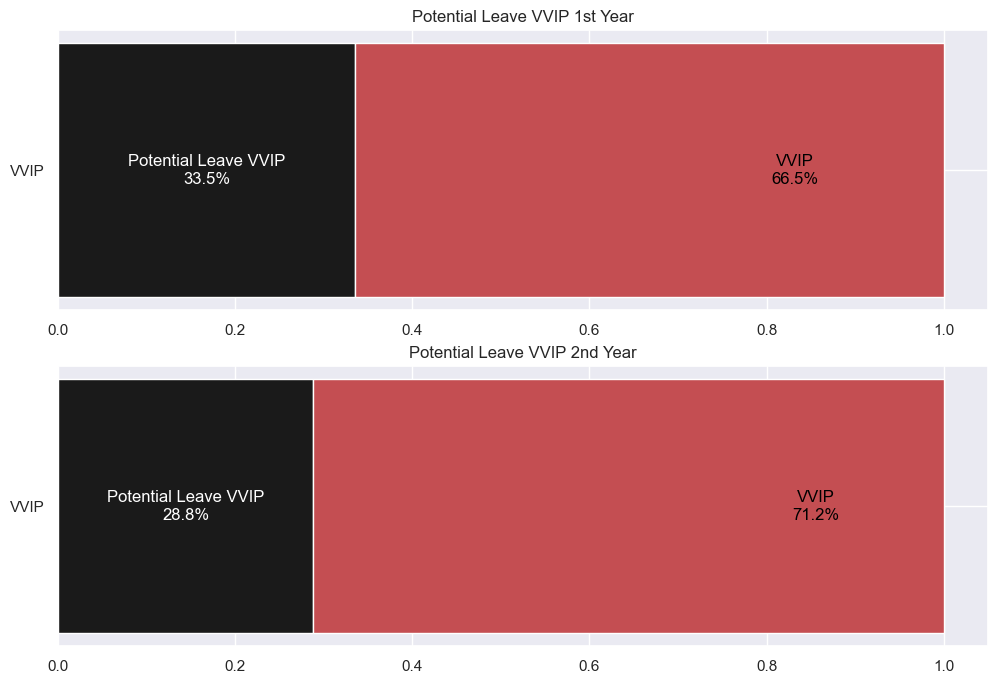

In [17]:
# 각 해의 VVIP 고객들에 대한 각 해의 VVIP 고객들 중 이탈 가능성이 있는 고객들의 비율을 시각화
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.barh(['VVIP'], [len(first_year_potential_leave_VVIP) / len(first_year_vvip)], color='k')
ax1.barh(['VVIP'], [1 - len(first_year_potential_leave_VVIP) / len(first_year_vvip)], left=[len(first_year_potential_leave_VVIP) / len(first_year_vvip)], color='r')
ax1.set_title('Potential Leave VVIP 1st Year')

ax2.barh(['VVIP'], [len(second_year_potential_leave_VVIP) / len(second_year_vvip)], color='k')
ax2.barh(['VVIP'], [1 - len(second_year_potential_leave_VVIP) / len(second_year_vvip)], left=[len(second_year_potential_leave_VVIP) / len(second_year_vvip)], color='r')
ax2.set_title('Potential Leave VVIP 2nd Year')

# 차트에 항목 및 비율 표시
ax1.text(len(first_year_potential_leave_VVIP) / len(first_year_vvip) / 2, 0, f'Potential Leave VVIP\n{len(first_year_potential_leave_VVIP) / len(first_year_vvip) * 100:.1f}%', ha='center', va='center', color='white')
ax1.text(1 - len(first_year_potential_leave_VVIP) / len(first_year_vvip) / 2, 0, f'VVIP\n{(1 - len(first_year_potential_leave_VVIP) / len(first_year_vvip)) * 100:.1f}%', ha='center', va='center', color='black')

ax2.text(len(second_year_potential_leave_VVIP) / len(second_year_vvip) / 2, 0, f'Potential Leave VVIP\n{len(second_year_potential_leave_VVIP) / len(second_year_vvip) * 100:.1f}%', ha='center', va='center', color='white')
ax2.text(1 - len(second_year_potential_leave_VVIP) / len(second_year_vvip) / 2, 0, f'VVIP\n{(1 - len(second_year_potential_leave_VVIP) / len(second_year_vvip)) * 100:.1f}%', ha='center', va='center', color='black')

plt.show()

---

## 코호트

In [18]:
# 2010년 12월부터 2011년 11월까지 구매 기록이 있는 고객의 ID를 추출
customers_2010_2011 = retail[(retail['InvoiceDate'].between('2010-12-01 00:00:00', '2011-11-30 23:59:59'))]['Customer ID'].unique()

# 2009년 12월부터 2010년 11월까지 구매 기록이 있는 고객의 ID를 추출
customers_2009_2010 = retail[(retail['InvoiceDate'].between('2009-12-01 00:00:00', '2010-11-30 23:59:59'))]['Customer ID'].unique()

# customers_2010_2011에 있는 고객 중 customers_2009_2010에 없는 고객들만 추출
customers_only_2010_2011 = np.setdiff1d(customers_2010_2011, customers_2009_2010)

# retail 데이터프레임에서 customers_only_2010_2011에 해당하는 고객들의 데이터만 추출
retail_new_customer = retail[retail['Customer ID'].isin(customers_only_2010_2011)]
retail_new_customer.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,CheckoutPrice,Year,Month
387631,536502,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2010-12-01 12:36:00,1.69,16552.0,United Kingdom,27.04,2010,12
387632,536502,22784,LANTERN CREAM GAZEBO,3,2010-12-01 12:36:00,4.95,16552.0,United Kingdom,14.85,2010,12
387633,536502,21441,BLUE BIRDHOUSE DECORATION,12,2010-12-01 12:36:00,0.85,16552.0,United Kingdom,10.20,2010,12
387634,536502,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 12:36:00,2.95,16552.0,United Kingdom,17.70,2010,12
387635,536502,22423,REGENCY CAKESTAND 3 TIER,2,2010-12-01 12:36:00,12.75,16552.0,United Kingdom,25.50,2010,12


In [19]:
# 필요한 열만 추출해서 새로운 데이터프레임 생성
df_cohort = retail_new_customer[['Invoice', 'InvoiceDate', 'Customer ID']].copy()

# 각 고객당 최초 구매월을 계산
df_cohort['FirstPurchaseMonth'] = df_cohort.groupby('Customer ID')['InvoiceDate'].transform('min').dt.to_period('M')

# 모든 열이 같은 중복 행 제거
df_cohort = df_cohort.drop_duplicates()

# InvoiceDate 열을 년-월 형식으로 변환
df_cohort['InvoiceDate'] = df_cohort['InvoiceDate'].dt.to_period('M')

# 최초 구매월과 구매월 간의 차이를 계산
df_cohort['MonthPassed'] = (df_cohort['InvoiceDate'] - df_cohort['FirstPurchaseMonth']).apply(lambda x: x.n)
df_cohort.head()

,Invoice,InvoiceDate,Customer ID,FirstPurchaseMonth,MonthPassed
387631,536502,2010-12,16552.0,2010-12,0
388020,536537,2010-12,15922.0,2010-12,0
388031,536538,2010-12,14594.0,2010-12,0
388062,536539,2010-12,15165.0,2010-12,0
388308,536569,2010-12,16274.0,2010-12,0


In [20]:
# FirstPurchaseMonth와 MonthPassed 열을 기준으로 그룹화하여 고객 수를 계산
cohort_group = df_cohort.groupby(['FirstPurchaseMonth', 'MonthPassed'])
cohort = cohort_group['Customer ID'].apply(pd.Series.nunique).reset_index()

# 피벗 테이블 생성
cohort_table = cohort.pivot(index='FirstPurchaseMonth', columns='MonthPassed', values='Customer ID')
cohort_table

MonthPassed,0,1,2,3,4,5,6,7,8,9,10,11
FirstPurchaseMonth,,,,,,,,,,,,
2010-12,76.0,7.0,4.0,7.0,9.0,5.0,4.0,7.0,4.0,2.0,7.0,15.0
2011-01,71.0,12.0,15.0,14.0,15.0,11.0,11.0,9.0,8.0,15.0,18.0,NaN
2011-02,124.0,20.0,19.0,23.0,27.0,19.0,19.0,18.0,18.0,22.0,NaN,NaN
2011-03,179.0,33.0,39.0,36.0,40.0,27.0,37.0,36.0,43.0,NaN,NaN,NaN
2011-04,106.0,27.0,21.0,21.0,19.0,25.0,19.0,27.0,NaN,NaN,NaN,NaN
2011-05,111.0,26.0,27.0,18.0,24.0,23.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06,108.0,25.0,23.0,29.0,22.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,102.0,22.0,31.0,28.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,106.0,29.0,33.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


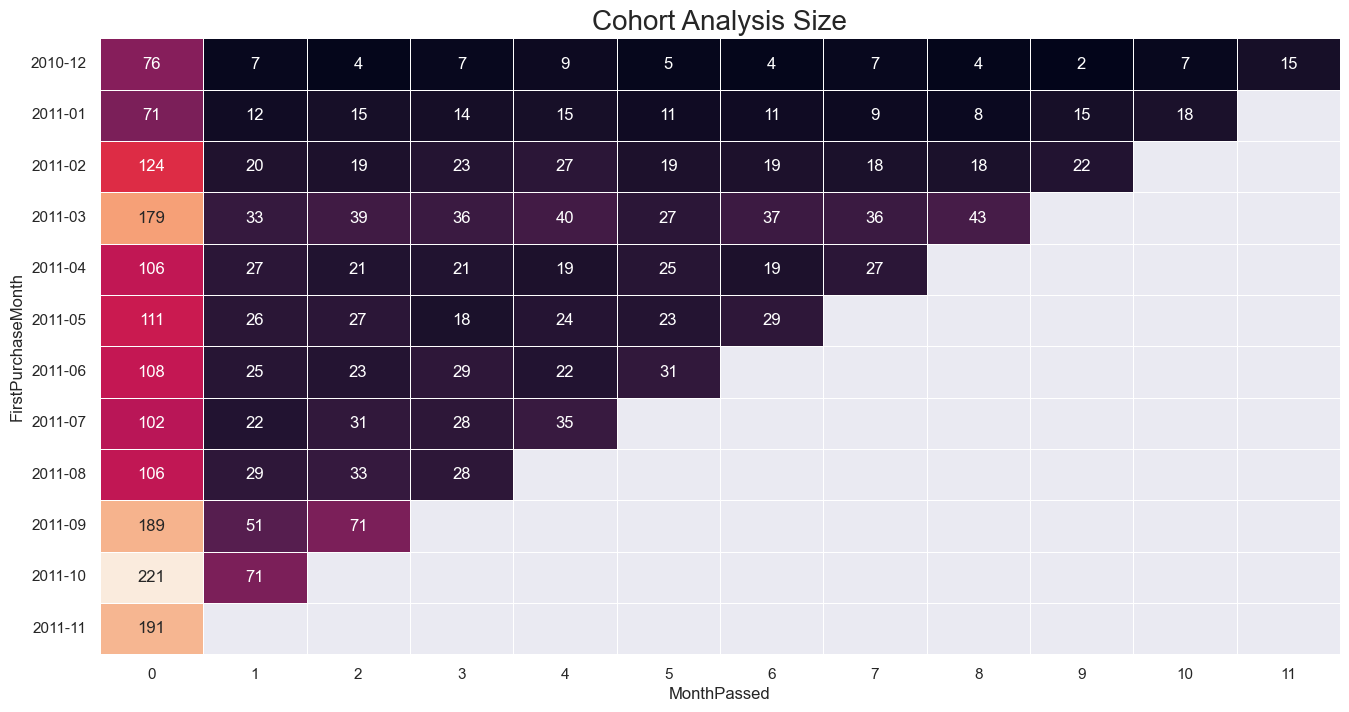

In [32]:
# 히트맵 생성
plt.figure(figsize=(16, 8))
plt.title('Cohort Analysis Size', fontsize=20)
sns.heatmap(cohort_table, annot=True, fmt='.0f', linewidths=0.5, cbar=False)
plt.show()

In [22]:
cohort_percentage = cohort_table.divide(cohort_table.iloc[:, 0], axis=0) * 100
cohort_percentage = cohort_percentage.round(2)
cohort_percentage

MonthPassed,0,1,2,3,4,5,6,7,8,9,10,11
FirstPurchaseMonth,,,,,,,,,,,,
2010-12,100.0,9.21,5.26,9.21,11.84,6.58,5.26,9.21,5.26,2.63,9.21,19.74
2011-01,100.0,16.90,21.13,19.72,21.13,15.49,15.49,12.68,11.27,21.13,25.35,NaN
2011-02,100.0,16.13,15.32,18.55,21.77,15.32,15.32,14.52,14.52,17.74,NaN,NaN
2011-03,100.0,18.44,21.79,20.11,22.35,15.08,20.67,20.11,24.02,NaN,NaN,NaN
2011-04,100.0,25.47,19.81,19.81,17.92,23.58,17.92,25.47,NaN,NaN,NaN,NaN
2011-05,100.0,23.42,24.32,16.22,21.62,20.72,26.13,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,23.15,21.30,26.85,20.37,28.70,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,21.57,30.39,27.45,34.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,27.36,31.13,26.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


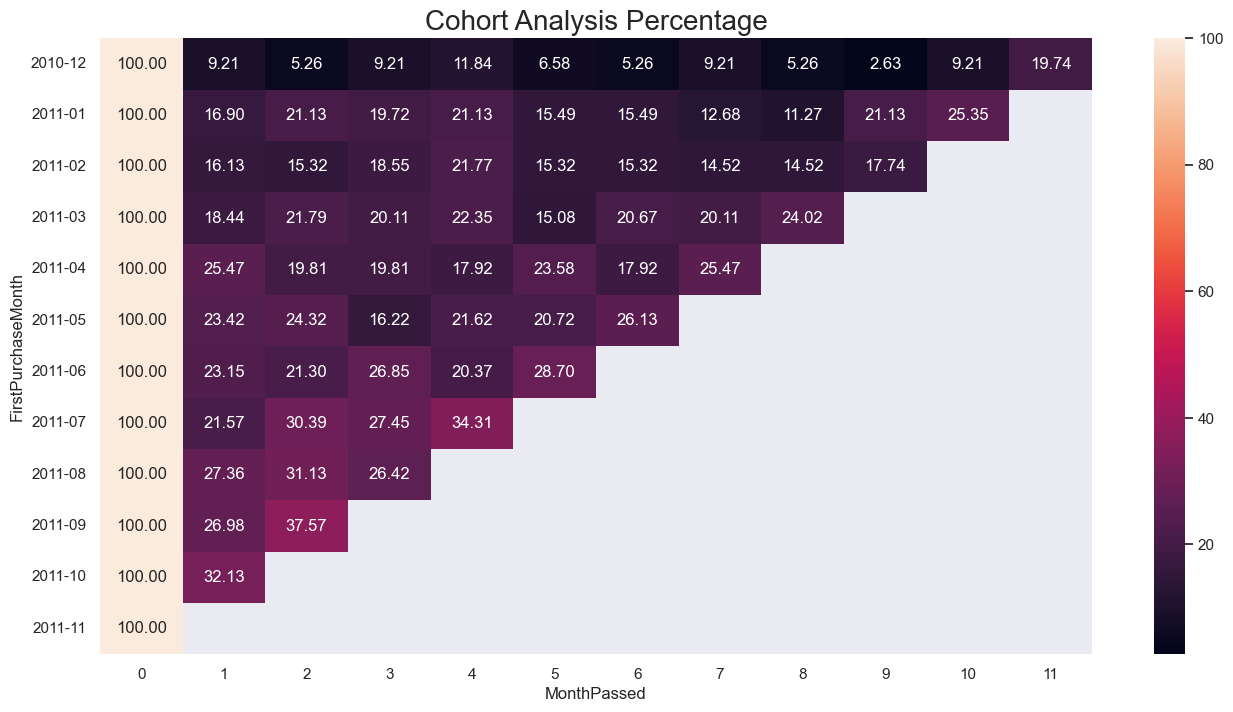

In [33]:
# 히트맵 생성
plt.figure(figsize=(16, 8))
plt.title('Cohort Analysis Percentage', fontsize=20)
sns.heatmap(cohort_percentage, annot=True, fmt='.2f')
plt.show()

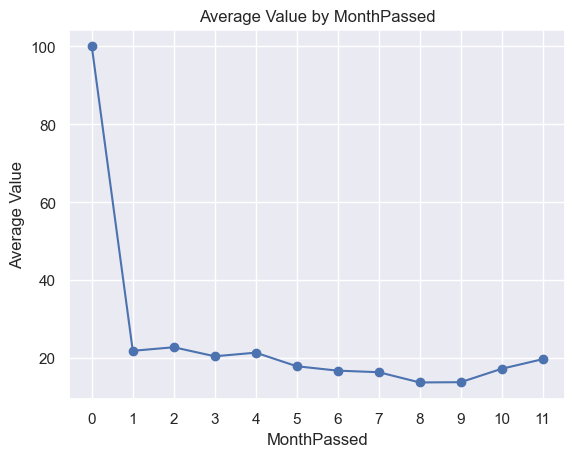

In [29]:
average_values = cohort_percentage.mean()
average_values.plot(kind='line', marker='o')
plt.xlabel('MonthPassed')
plt.ylabel('Average Value')
plt.title('Average Value by MonthPassed')
plt.xticks(range(len(average_values)), average_values.index)
plt.show()

In [34]:
average_values

MonthPassed
0     100.000000
1      21.887273
2      22.802000
3      20.482222
4      21.413750
5      17.924286
6      16.798333
7      16.398000
8      13.767500
9      13.833333
10     17.280000
11     19.740000
dtype: float64

---

In [25]:
# 모든 고객 각각의 평균 재구매 기간 계산하고 데이터프레임 생성
retail_sorted = retail.sort_values(['Customer ID', 'InvoiceDate'])
retail_sorted['PurchaseDiff'] = retail_sorted.groupby('Customer ID')['InvoiceDate'].diff().dt.days
average_repurchase_period = retail_sorted.groupby('Customer ID')['PurchaseDiff'].mean().round()

average_repurchase_period_df = average_repurchase_period.to_frame()
average_repurchase_period_df.columns = ['Average Repurchase Period']
average_repurchase_period_df.reset_index(inplace=True)

average_repurchase_period_df

,Customer ID,Average Repurchase Period
0,12346.0,12.0
1,12347.0,2.0
2,12348.0,7.0
3,12349.0,3.0
4,12350.0,0.0
...,...,...
5845,18283.0,1.0
5846,18284.0,0.0
5847,18285.0,0.0
5848,18286.0,4.0


In [26]:
# 전체 모든 고객의 평균 재구매 기간(0인 값 제외)
average_repurchase_period_df[average_repurchase_period_df['Average Repurchase Period'] != 0]['Average Repurchase Period'].mean()

7.454080327449476

In [27]:
# 모든 고객 각각의 가장 많이 구매한 시간대 계산하고 데이터프레임 생성
purchase_time = retail.groupby('Customer ID')['InvoiceDate'].apply(lambda x: x.dt.hour.mode()[0])
purchase_time_df = pd.DataFrame({'Customer ID': purchase_time.index, 'Most Frequent Purchase Time': purchase_time.values})

purchase_time_df

,Customer ID,Most Frequent Purchase Time
0,12346.0,13
1,12347.0,14
2,12348.0,14
3,12349.0,9
4,12350.0,16
...,...,...
5845,18283.0,13
5846,18284.0,11
5847,18285.0,10
5848,18286.0,11
